In [1]:
import sys
import os
import glob
import shutil
import numpy as np
import cv2
import lmdb
import random

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
sys.path.insert(0, '/Users/nathaning/software/caffe-segnet-crf/python')
import caffe
from caffe.proto import caffe_pb2

# Random crops

In [122]:
image_source = '/Users/nathaning/databases/pca/original_feature'
mask_source = '/Users/nathaning/databases/pca/original_annotation'

img_list = sorted(glob.glob(
    os.path.join(image_source, '*.jpg')
))

mask_list = sorted(glob.glob(
    os.path.join(mask_source, '*.png')
))

c = zip(img_list, mask_list)
random.shuffle(c)
img_list, mask_list = zip(*c)

print 'Found {} images in {}'.format(len(img_list), image_source)
print 'Found {} images in {}'.format(len(mask_list), mask_source)

sampleimg = cv2.imread(img_list[0])
h,w = sampleimg.shape[:2]
print h,w

winwrite = 128

# winsize = 256
# scale = 2
# winwrite = winsize / scale
# n = 10
# r = lambda: np.random.randint(h-winsize)
# coords = [[(r(), r()) for _ in range(n)] for _ in img_list]


'''
Create an lmdb database of images

'''
image_train_db = '/Users/nathaning/databases/pca/feature_lmdb'
mask_train_db = '/Users/nathaning/databases/pca/mask_lmdb'
image_test_db = '/Users/nathaning/databases/pca/feature_test_lmdb'
mask_test_db = '/Users/nathaning/databases/pca/mask_test_lmdb'
debug_dir = '/Users/nathaning/databases/pca/debug'

if os.path.exists(image_db): shutil.rmtree(image_db)
if os.path.exists(mask_db): shutil.rmtree(mask_db)

ntrain = int(len(img_list) * 0.9)
safety = 10
est_total = sampleimg.nbytes * len(img_list) * safety

'''
Do the Train Feature DB write
'''
env = lmdb.open(image_train_db, map_size=est_total)
index = 1
with env.begin(write=True) as txn:
    for k, img_name in enumerate(img_list[:ntrain]):
        img = cv2.imread(img_name)

        #         for box in crops:
#         x = box[0]
#         y = box[1]
        #         subimg_ = img[x:x+winsize, y:y+winsize, :]
        subimg_ = cv2.resize(img, dsize=(winwrite, winwrite),
                            interpolation=cv2.INTER_CUBIC)

        # From BVLC/caffe/issues/1698
        subimg = subimg_[:,:,::-1]
        subimg = subimg.transpose((2,0,1))

        datum = caffe.io.array_to_datum(subimg)
        str_id = '{:07}'.format(index)

        txn.put(str_id.encode('ascii'), datum.SerializeToString())
        if index % 30 == 0:
            print str_id
            cv2.imwrite(os.path.join(debug_dir, '{}.png'.format(str_id)), subimg_)

        index += 1
        
print 'added {} files to {}'.format(k, image_train_db)            
env.close()

'''
Do the Train Mask DB write
'''
env = lmdb.open(mask_train_db, map_size=est_total)
index = 1
with env.begin(write=True) as txn:
    for k, img_name in enumerate(mask_list[:ntrain]):
        img = cv2.imread(img_name, 0)
        img_ = np.copy(img)
        img_[img==0]=0
        img_[img==1]=0
        img_[img==2]=0
        img_[img==3]=1
        
        #         img = img > 0
        #         img.dtype = np.uint8

        #         for box in crops:
#         x = box[0]
#         y = box[1]
        #         subimg_ = img[x:x+winsize, y:y+winsize]
        subimg_ = cv2.resize(img_, dsize=(winwrite, winwrite),
                             interpolation=cv2.INTER_NEAREST)
        subimg = np.expand_dims(subimg_, 0)

        datum = caffe.io.array_to_datum(subimg)
        str_id = '{:07}'.format(index)

        txn.put(str_id.encode('ascii'), datum.SerializeToString())
        if index % 30 == 0:
            print str_id
            cv2.imwrite(os.path.join(debug_dir, '{}_.png'.format(str_id)), 
                        subimg_*(255/subimg_.max()) )

        index += 1
        
        
print 'added {} files to {}'.format(k, mask_train_db)
env.close()


'''
Do the Test Feature DB write
'''
env = lmdb.open(image_test_db, map_size=est_total)
index = 1
with env.begin(write=True) as txn:
    for k, img_name in enumerate(img_list[ntrain:]):
        img = cv2.imread(img_name)

        #         for box in crops:
#         x = box[0]
#         y = box[1]
        #         subimg_ = img[x:x+winsize, y:y+winsize, :]
        subimg_ = cv2.resize(img, dsize=(winwrite, winwrite),
                            interpolation=cv2.INTER_CUBIC)

        # From BVLC/caffe/issues/1698
        subimg = subimg_[:,:,::-1]
        subimg = subimg.transpose((2,0,1))

        datum = caffe.io.array_to_datum(subimg)
        str_id = '{:07}'.format(index)

        txn.put(str_id.encode('ascii'), datum.SerializeToString())
        if index % 3 == 0:
            print str_id
            cv2.imwrite(os.path.join(debug_dir, '{}.png'.format(str_id)), subimg_)

        index += 1
        
print 'added {} files to {}'.format(k, image_test_db)            
env.close()

'''
Do the Test Mask DB write
'''
env = lmdb.open(mask_test_db, map_size=est_total)
index = 1
with env.begin(write=True) as txn:
    for k, img_name in enumerate(mask_list[ntrain:]):
        img = cv2.imread(img_name, 0)
        img_ = np.copy(img)
        img_[img==0]=0
        img_[img==1]=0
        img_[img==2]=0
        img_[img==3]=1
        
        #         img = img > 0
        #         img.dtype = np.uint8

        #         for box in crops:
#         x = box[0]
#         y = box[1]
        #         subimg_ = img[x:x+winsize, y:y+winsize]
        subimg_ = cv2.resize(img_, dsize=(winwrite, winwrite),
                             interpolation=cv2.INTER_NEAREST)
        subimg = np.expand_dims(subimg_, 0)

        datum = caffe.io.array_to_datum(subimg)
        str_id = '{:07}'.format(index)

        txn.put(str_id.encode('ascii'), datum.SerializeToString())
        if index % 3 == 0:
            print str_id
            cv2.imwrite(os.path.join(debug_dir, '{}_.png'.format(str_id)), 
                        subimg_*(255/subimg_.max()) )

        index += 1
        
        
print 'added {} files to {}'.format(k, mask_test_db)
env.close()
print 'done'

Found 224 images in /Users/nathaning/databases/pca/original_feature
Found 224 images in /Users/nathaning/databases/pca/original_annotation
1201 1201
0000030
0000060
0000090
0000120
0000150
0000180
added 200 files to /Users/nathaning/databases/pca/feature_lmdb
0000030
0000060
0000090
0000120
0000150
0000180
added 200 files to /Users/nathaning/databases/pca/mask_lmdb
0000003
0000006
0000009
0000012
0000015
0000018
0000021
added 22 files to /Users/nathaning/databases/pca/feature_test_lmdb
0000003
0000006
0000009
0000012
0000015
0000018
0000021
added 22 files to /Users/nathaning/databases/pca/mask_test_lmdb
done


[  0  38  75 113]
uint8


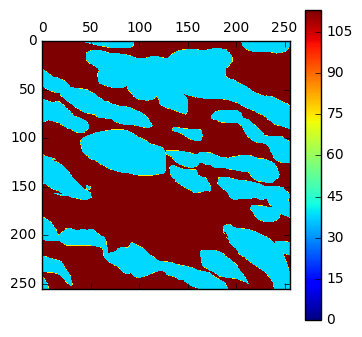

In [107]:
img = cv2.imread(mask_list[np.random.randint(224)], 0)
print np.unique(img)
print img.dtype
plt.matshow(img); plt.colorbar()

In [ ]:
labeldict = {0: 0, 38: 1, 75: 2, 113: 3}

[0 3]
uint8


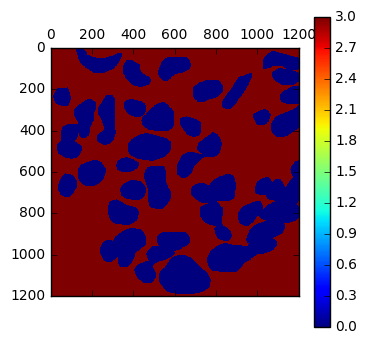

In [113]:
og_mask = '/Users/nathaning/databases/pca/original_annotation'
og_list = sorted(glob.glob(os.path.join(og_mask, '*.png')))

img = cv2.imread(og_list[np.random.randint(100)], 0)
print np.unique(img)
print img.dtype
plt.matshow(img); plt.colorbar()

In [4]:
image_source = '/Users/nathaning/databases/pca/seg_0.1/feat'
mask_source = '/Users/nathaning/databases/pca/seg_0.1/anno'

img_list = sorted(glob.glob(
    os.path.join(image_source, '*.jpg')
))

mask_list = sorted(glob.glob(
    os.path.join(mask_source, '*.png')
))

c = zip(img_list, mask_list)
random.shuffle(c)
img_list, mask_list = zip(*c)

print img_list[0], mask_list[0]


/Users/nathaning/databases/pca/seg_0.1/feat/test224sc.jpg /Users/nathaning/databases/pca/seg_0.1/anno/test224sc.png


## If necessary do copy first

In [123]:
src = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1'
feature = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1_original'

feature_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_feature_test'
outline_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_outline_test'
mask_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_mask_test'
label_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_label_test'

src_list = sorted(glob.glob(
    os.path.join(src, '*.png')
))

feature_list = sorted(glob.glob(
    os.path.join(feature, '*.tif')
))

outline_list = [img for img in src_list if 'tif.png' in img]
mask_list = [img for img in src_list if '_mask' in img]
label_list = [img for img in src_list if 'Lmask' in img]

print feature_list[0]
print img_list[0]
print mask_list[0]
print label_list[0]

rep = lambda x: os.path.join(feature_dest, os.path.basename(x))
_ = [shutil.copyfile(img, rep(img)) for img in feature_list]
print 'Done copying originals'

rep = lambda x: os.path.join(outline_dest, os.path.basename(x.replace('.tif', '')))
_ = [shutil.copyfile(img, rep(img)) for img in img_list]
print 'Done copying outlines'

rep = lambda x: os.path.join(mask_dest, os.path.basename(x.replace('.tif_mask', '')))
_ = [shutil.copyfile(img, rep(img)) for img in mask_list]
print 'Done copying masks'

rep = lambda x: os.path.join(label_dest, os.path.basename(x.replace('.tif_Lmask', '')))
_ = [shutil.copyfile(img, rep(img)) for img in label_list]
print 'Done copying labels'

/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1_original/SP 02-4466 L3_001(5+5)_1_2.tif
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_feature/SP 04-1514 1 L3_001(3+4)_2_4.tif
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1/SP 02-4466 L3_001(5+5)_1_2.tif_mask.png
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1/SP 02-4466 L3_001(5+5)_1_2.tif_Lmask.png
Done copying originals
Done copying outlines
Done copying masks
Done copying labels
